In [1]:
import torch_geometric

import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

# ref: https://medium.com/stanford-cs224w/fraud-detection-with-gat-edac49bda1a0

#### Import dataset

In [2]:
# import data 
df_features = pd.read_csv('data/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("data/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("data/elliptic_txs_classes.csv")

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge.drop(0, axis=1, inplace=True)

# check if there are duplicate txId
print("Number of duplicate txId: ", df_merge.duplicated(subset=['txId']).sum())

# rename column 0 to time_step
df_merge.rename(columns={1: 'time_step'}, inplace=True)
display(df_merge.head())
display(df_edges.shape)
edges = df_edges.copy()

# Setup trans ID to node ID mapping
nodes = df_merge['txId'].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Map transction IDs to node Ids
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

# Reformat and convert to tensor
edge_index = np.array(edges.values).T 
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

print("shape of edge index is {}".format(edge_index.shape))
node_features = df_merge.drop(['txId'], axis=1).copy()
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
all_classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
all_unclassified_idx = node_features['class'].loc[node_features['class']==2].index
all_classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
all_classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# node_features = node_features.drop(columns=[0, 1, 'class'])
display(node_features.head())
train_classified_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] != 2)].index
test_classified_idx = node_features.loc[(node_features['time_step'] > 34) & (node_features['class'] != 2)].index
print("train_classified_idx.shape=",train_classified_idx.shape)
print("test_classified_idx.shape=",test_classified_idx.shape)
# show ratio of illicit vs licit transactions in train and test set
train_classified_illicit_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] == 1)].index
train_classified_licit_idx = node_features.loc[(node_features['time_step'] <= 34) & (node_features['class'] == 0)].index
print("train_classified_illicit_idx.shape=",train_classified_illicit_idx.shape)
print("train_classified_licit_idx.shape=",train_classified_licit_idx.shape)
print("train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0]=",train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0])
# save the train and test indices as csv, integer
# np.savetxt("../data/index/train_classified_idx.csv", train_classified_idx, delimiter=",", fmt='%d')
# np.savetxt("../data/index/test_classified_idx.csv", test_classified_idx, delimiter=",", fmt='%d')
temp_node_features = node_features.copy()
# node_features.drop(columns=['time_step'], inplace=True)
node_features.drop(columns=['class'], inplace=True)

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)
# Define labels
labels = df_merge['class'].values

#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

# Do train test split on classified_ids
train_idx = train_classified_idx
test_idx = test_classified_idx

# Create pyG dataset
data_graph = Data(x=node_features_t.float(), edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.long))

# Add in the train and valid idx
data_graph.train_idx = train_idx
data_graph.test_idx = test_idx
data_graph

Number of duplicate txId:  0


,time_step,2,3,4,5,6,7,8,9,10,...,159,160,161,162,163,164,165,166,txId,class
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2


(234355, 2)

shape of edge index is torch.Size([2, 234355])
unique= [2 0 1]


,time_step,2,3,4,5,6,7,8,9,10,...,158,159,160,161,162,163,164,165,166,class
0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
1,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,2
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
4,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,2


train_classified_idx.shape= (29894,)
test_classified_idx.shape= (16670,)
train_classified_illicit_idx.shape= (3462,)
train_classified_licit_idx.shape= (26432,)
train_classified_illicit_idx.shape[0]/train_classified_idx.shape[0]= 0.11580919248009634


Data(x=[203769, 166], edge_index=[2, 234355], edge_attr=[234355], y=[203769], train_idx=Int64Index([     3,      9,     10,     11,     16,     17,     25,     27,
                29,     30,
            ...
            136232, 136233, 136234, 136236, 136239, 136241, 136243, 136249,
            136250, 136258],
           dtype='int64', length=29894), test_idx=Int64Index([136276, 136277, 136278, 136279, 136280, 136282, 136285, 136287,
            136288, 136291,
            ...
            203727, 203730, 203736, 203740, 203750, 203752, 203754, 203759,
            203763, 203766],
           dtype='int64', length=16670))

#### GCN Model and Training

In [5]:
# 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
CLASS_WEIGTHS = [0.7,0.3]

def train(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # out = out.reshape((data.x.shape[0]))
    # use weighted cross entropy loss, weighted cross entropy loss to provide higher importance to the illicit samples.
    weights = torch.tensor(CLASS_WEIGTHS, dtype=torch.float).to(device)
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx], weight=weights)
    loss.backward()
    optimizer.step()
    return loss

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        y = data.y[data.test_idx]
        # metrics for illicit transactions
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu(), average='binary')
        precision = precision_score(y.cpu(), pred.cpu(), average='binary')
        recall = recall_score(y.cpu(), pred.cpu(), average='binary')
        return acc, f1, precision, recall
    
num_features = data_graph.num_node_features
print("num_features=",num_features)
model = GCN(num_features, 2).to(device)
num_epochs = 500
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_metric_list = []
max_f1 = 0

for epoch in range(num_epochs+1):
    loss = train(model, data_graph, optimizer)
    acc, f1, precision, recall = test(model, data_graph)
    # save metrics list when f1 is max
    if f1 > max_f1:
        max_f1 = f1
        best_metric_list = [acc, f1, precision, recall]
    
    if epoch % 10 == 0:
        # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
        ...
print(f'best: Accuracy: {best_metric_list[0]:.4f}, F1: {best_metric_list[1]:.4f}, Precision: {best_metric_list[2]:.4f}, Recall: {best_metric_list[3]:.4f}')

num_features= 166
best: Accuracy: 0.9186, F1: 0.4233, Precision: 0.3921, Recall: 0.4598


In [31]:
import torch
from torch_geometric.nn import GCNConv

class TGCN(torch.nn.Module):
    r"""An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
    For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
    Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
    ):
        super(TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops

        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_z = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_r = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_h = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=1)
        Z = self.linear_z(Z)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=1)
        R = self.linear_r(R)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=1)
        H_tilde = self.linear_h(H_tilde)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.

        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

def train(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # out = out.reshape((data.x.shape[0]))
    # TODO :use weighted cross entropy loss
    loss = F.cross_entropy(out[data.train_idx], data.y[data.train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        pred_scores = out[data.test_idx]
        pred = torch.argmax(pred_scores, dim=1)
        # print(sum([1 for i in pred.tolist() if i == 1]))
        y = data.y[data.test_idx]
        acc = accuracy_score(y.cpu(), pred.cpu())
        f1 = f1_score(y.cpu(), pred.cpu())
        precision = precision_score(y.cpu(), pred.cpu())
        recall = recall_score(y.cpu(), pred.cpu())
        roc = roc_auc_score(y.cpu(), pred.cpu())
        return acc, f1, precision, recall

num_features = data_graph.num_node_features
device = torch.device('cpu')

model_tgcn = TGCN(in_channels=num_features, out_channels=2)
num_epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model_tgcn.parameters(), lr=lr)

best_metric_list = []
max_f1 = 0

for epoch in range(num_epochs+1):
    loss = train(model_tgcn, data_graph, optimizer)
    acc, f1, precision, recall = test(model_tgcn, data_graph)
    if f1 > max_f1:
        max_f1 = f1
        best_metric_list = [acc, f1, precision, recall]
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, recall: {recall:.4f}')
# print(f'best: Accuracy: {best_metric_list[0]:.4f}, F1: {best_metric_list[1]:.4f}, Precision: {best_metric_list[2]:.4f}, Recall: {best_metric_list[3]:.4f}')
print(best_metric_list)

Epoch: 0, Loss: 0.8804, Acc: 0.1176, F1: 0.2105, Precision: 0.1176, recall: 1.0000
Epoch: 10, Loss: 0.7840, Acc: 0.1261, F1: 0.2121, Precision: 0.1186, recall: 1.0000
Epoch: 20, Loss: 0.7011, Acc: 0.1324, F1: 0.2133, Precision: 0.1194, recall: 1.0000
Epoch: 30, Loss: 0.6387, Acc: 0.1429, F1: 0.2154, Precision: 0.1207, recall: 1.0000
Epoch: 40, Loss: 0.5968, Acc: 0.1639, F1: 0.2196, Precision: 0.1233, recall: 1.0000
Epoch: 50, Loss: 0.5658, Acc: 0.2206, F1: 0.2319, Precision: 0.1311, recall: 1.0000
Epoch: 60, Loss: 0.5393, Acc: 0.3529, F1: 0.2667, Precision: 0.1538, recall: 1.0000
Epoch: 70, Loss: 0.5160, Acc: 0.4706, F1: 0.3077, Precision: 0.1818, recall: 1.0000
Epoch: 80, Loss: 0.4954, Acc: 0.5231, F1: 0.3304, Precision: 0.1979, recall: 1.0000
Epoch: 90, Loss: 0.4771, Acc: 0.5588, F1: 0.3438, Precision: 0.2083, recall: 0.9821
Epoch: 100, Loss: 0.4605, Acc: 0.5987, F1: 0.3612, Precision: 0.2222, recall: 0.9643
[0.5987394957983193, 0.3612040133779264, 0.2222222222222222, 0.9642857142857

## GCN testing per time step

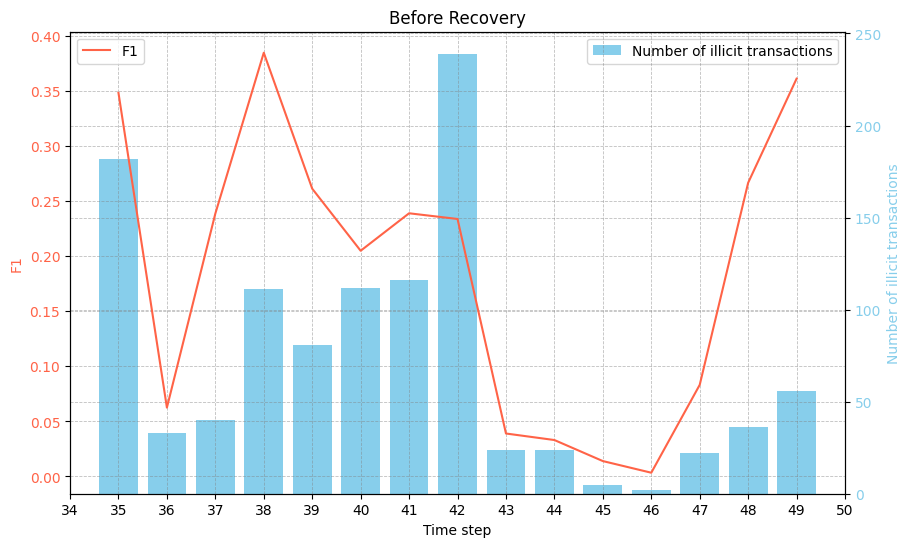

In [32]:
# test 
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model_tgcn, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='grey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('Before Recovery')

plt.show()


## GCN Black market shutdown testing

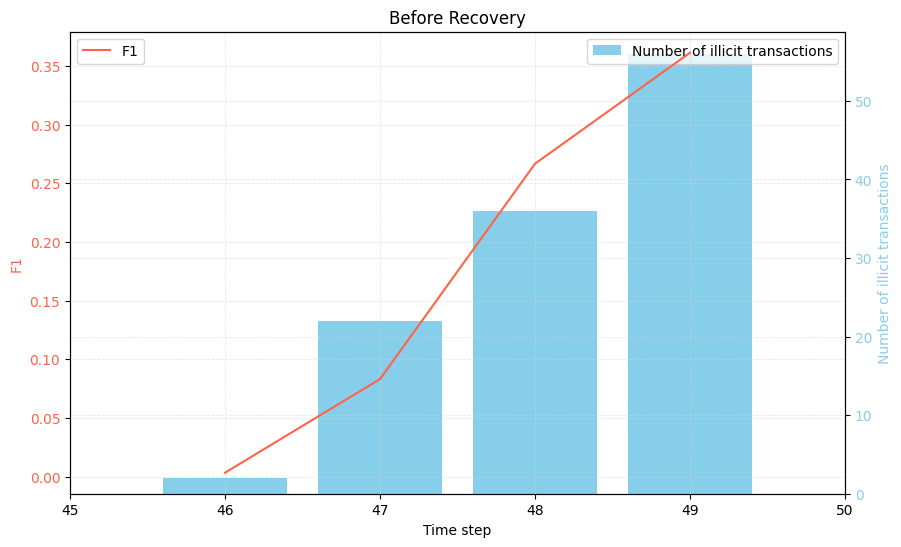

In [33]:
# test after shutdown
test_results = {}

for t in range(46, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model_tgcn, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('Before Recovery')

plt.show()

## GCN recovery testing

In [53]:
train_classified_idx = temp_node_features.loc[(((temp_node_features['time_step'] >= 43) & (temp_node_features['time_step'] <= 45)) | (temp_node_features['time_step'] <= 34)) & (temp_node_features['class'] != 2)].index
test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] > 45) & (temp_node_features['class'] != 2)].index

# train
data_graph.train_idx = train_classified_idx
data_graph.test_idx = test_classified_idx

model_tgcn_2 = TGCN(in_channels=num_features, out_channels=2).to(device)
num_epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model_tgcn_2.parameters(), lr=lr)

rec_best_metric_list = []
max_f1 = 0

for epoch in range(num_epochs+1):
    loss = train(model_tgcn_2, data_graph, optimizer)
    acc, f1, precision, recall = test(model_tgcn_2, data_graph)
    # save metrics list when f1 is max
    if f1 > max_f1:
        max_f1 = f1
        rec_best_metric_list = [acc, f1, precision, recall]
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
        ...
# print(f'best: Accuracy: {rec_best_metric_list[0]:.4f}, F1: {rec_best_metric_list[1]:.4f}, Precision: {rec_best_metric_list[2]:.4f}, Recall: {rec_best_metric_list[3]:.4f}')

Epoch: 000, Loss: 0.9322, Accuracy: 0.0467, F1: 0.0885, Precision: 0.0463, Recall: 1.0000
Epoch: 010, Loss: 0.8626, Accuracy: 0.0487, F1: 0.0887, Precision: 0.0464, Recall: 1.0000
Epoch: 020, Loss: 0.8049, Accuracy: 0.0567, F1: 0.0894, Precision: 0.0468, Recall: 1.0000
Epoch: 030, Loss: 0.7576, Accuracy: 0.1022, F1: 0.0928, Precision: 0.0487, Recall: 0.9914
Epoch: 040, Loss: 0.7181, Accuracy: 0.1513, F1: 0.0915, Precision: 0.0481, Recall: 0.9224
Epoch: 050, Loss: 0.6838, Accuracy: 0.2647, F1: 0.0935, Precision: 0.0496, Recall: 0.8190
Epoch: 060, Loss: 0.6495, Accuracy: 0.4647, F1: 0.1137, Precision: 0.0616, Recall: 0.7414
Epoch: 070, Loss: 0.6123, Accuracy: 0.6407, F1: 0.1211, Precision: 0.0683, Recall: 0.5345
Epoch: 080, Loss: 0.5743, Accuracy: 0.7804, F1: 0.1270, Precision: 0.0778, Recall: 0.3448
Epoch: 090, Loss: 0.5399, Accuracy: 0.8595, F1: 0.1156, Precision: 0.0816, Recall: 0.1983
Epoch: 100, Loss: 0.5089, Accuracy: 0.9090, F1: 0.1163, Precision: 0.1056, Recall: 0.1293


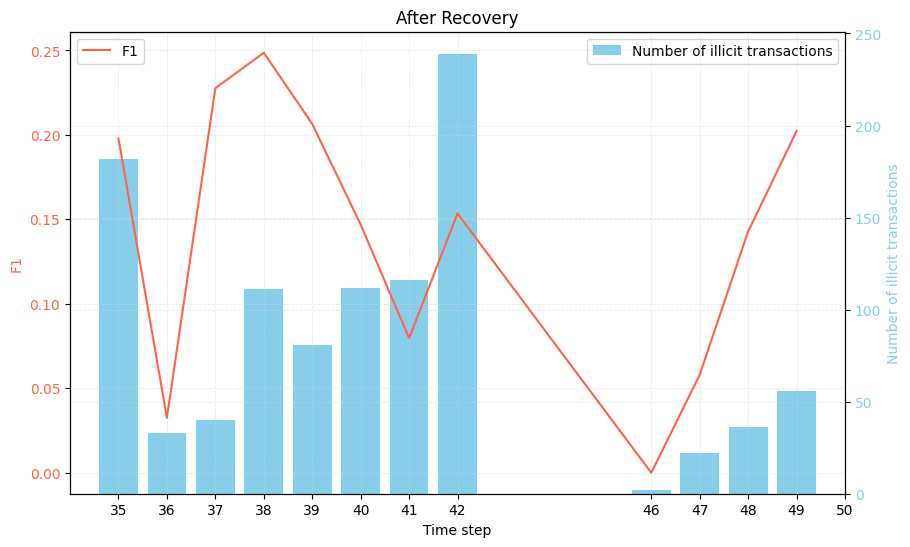

In [55]:
# test 
# test results on each time step of the test set and number of illicit transactions in each time step
# dict of test results on each time step and number of illicit transactions in each time step
test_results = {}

for t in range(35, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model_tgcn_2, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    

test_list = [35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50]
# remove the key-value pairs with key not in test_list
test_results = {key:val for key, val in test_results.items() if key in test_list}
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Changing bar color to dark blue and line color to solid orange
ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(34, 50)
# Legend
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

# Changing y-label colors to match their corresponding plot elements
ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

# Changing tick colors to match their corresponding plot elements
ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Show every tick number
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# remove 43, 44, 45 and it's line chart and bar chart
ax1.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])
ax2.set_xticks([35, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50])

# Enhancing grid visibility
ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

# To put ax1 (F1 line) in the front
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)

# add title
plt.title('After Recovery')

plt.show()


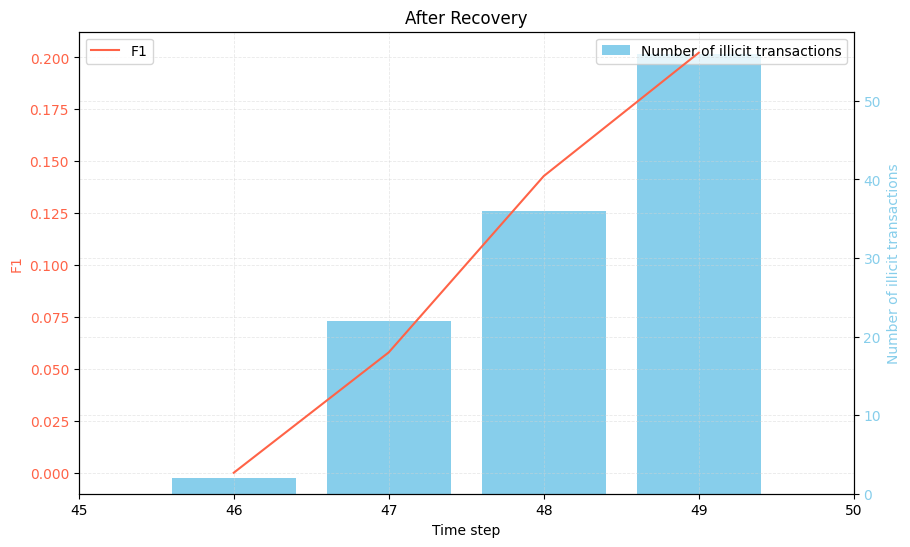

In [56]:
# test recovery
test_results = {}

for t in range(46, 50):
    test_classified_idx = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] != 2)].index
    data_graph.test_idx = test_classified_idx
    acc, f1, precision, recall = test(model_tgcn_2, data_graph)
    num_illicit = temp_node_features.loc[(temp_node_features['time_step'] == t) & (temp_node_features['class'] == 1)].shape[0]
    test_results[t] = [num_illicit, f1, acc, precision, recall]
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax2.bar(list(test_results.keys()), [x[0] for x in test_results.values()], color='skyblue', alpha=1)
ax1.plot(list(test_results.keys()), [x[1] for x in test_results.values()], color='tomato')
ax1.set_xlim(45, 50)
ax1.legend(['F1'], loc='upper left')
ax2.legend(['Number of illicit transactions'], loc='upper right')

ax1.set_xlabel('Time step')

ax1.set_ylabel('F1', color='tomato')
ax2.set_ylabel('Number of illicit transactions', color='skyblue')

ax1.tick_params(axis='y', labelcolor='tomato')
ax2.tick_params(axis='y', labelcolor='skyblue')

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax1.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.6, color='lightgrey', alpha=0.5)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
plt.title('After Recovery')


plt.show()